In [1]:
using Pkg
Pkg.activate("../..")

  Activating project at `~/Documents/repos/nanoOpt.jl`


In [2]:
using Measures,LinearAlgebra,LazyGrids,LaTeXStrings,QuadGK,Plots

In [3]:
using FastGaussQuadrature

In [4]:
using TimerOutputs

In [5]:
const to = TimerOutput();

In [6]:
include("../../src/NanoOpt.jl")

KsspSlab (generic function with 1 method)

In [7]:
mat1 = material(1.0^2,1.0)
matSc = material(epstable("gold"),1.0)
mat2 = material(1.5^2,1.0);

In [8]:
matScatter = [mat1; matSc];

In [9]:
layer = layerstructure([mat1,mat2],[0.0,],"up");

In [10]:
w,d = 55.,20.
rc = 2.
Nc,Nw,Nd = 3,15,5
xC = (0.,d/2. +0.);

In [11]:
rod = Rod(w,d,rc,Nc,Nw,Nd,xC);

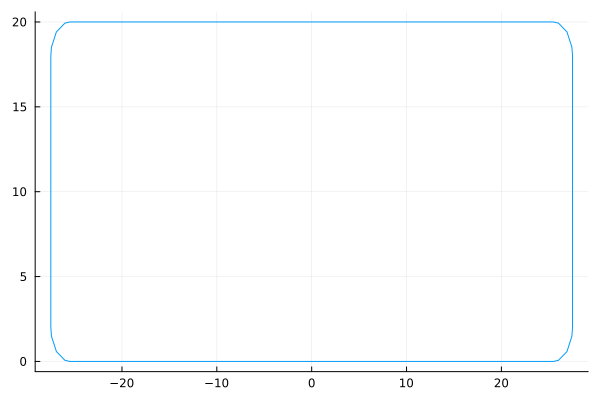

In [12]:
X,Y = getSurfPoints(rod)
plot(X,Y,legend=:none)

In [13]:
xm = (maximum(X)-minimum(X))+1;

In [14]:
yp = 2maximum(Y)+2
ym = 2minimum(Y);

In [15]:
yp

42.00000000000001

In [16]:
dThr = 50.
m = 2

2

In [17]:
i = 1

k0 = 2π/530
n₁ = mat1.n(k0)
n₂ = mat2.n(k0)
r = 500.
α = 90.

90.0

In [18]:
SParms = SommerfieldParams(layer,2k0);

In [19]:
@time Grf = GreenFunctions(matScatter,"layer";xP= (xm , 12), yP = (ym,yp,12), SParms = SParms);

 20.936241 seconds (73.64 M allocations: 3.195 GiB, 5.18% gc time, 46.05% compilation time)


In [20]:
@time H,ϕ = getHϕ(m,rod,k0,Grf,matSc.n,mat1.n,dThr,α,layer,"layer");

 23.717712 seconds (119.47 M allocations: 5.102 GiB, 7.69% gc time, 60.80% compilation time)


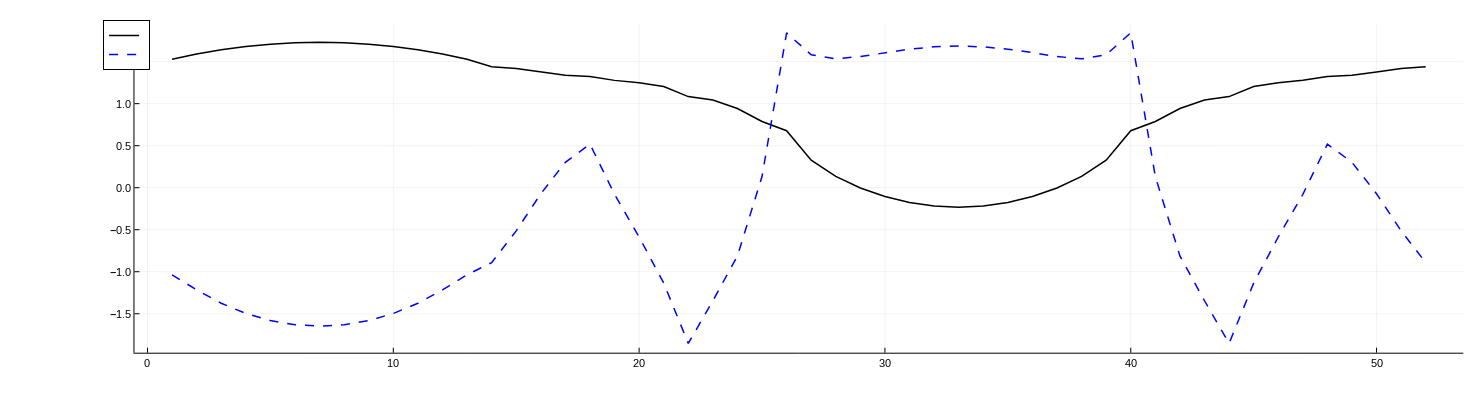

In [21]:
plotly()
plot(real.(H[:,3]),c=:black,lw=1.5,label=L"\Re\{ H(\mathbf{s}(t)) \}")
plot!(real.(ϕ[:,3])./k0,c=:blue,lw=1.5,ls=:dash,label=L"\Re\{ \phi(\mathbf{s}(t)) \}/ k_0",xlabel=L"t~[nm]",ylabel=L"Field",legend=:topleft)

# ========================================

In [22]:
θ = π-0.01

3.1315926535897933

In [23]:
Rf = 1000

1000

In [24]:
getHₛ(θ,Rf,ϕ,H,k0,m,rod,layer)

-0.00020193221386716068 - 0.0013882221667532845im

In [25]:
θA  = 0.1:0.01:π
θAn  = -0.1:-0.001:-π

-0.1:-0.001:-3.141

In [26]:
HsV = [getHₛ(θA[i],Rf,ϕ,H,k0,m,rod,layer) for i in eachindex(θA)];

In [27]:
HsVn = [getHₛ(θAn[i],Rf,ϕ,H,k0,m,rod,layer) for i in eachindex(θAn)];

In [28]:
c = layer.mat[end].n(k0)/layer.mat[1].n(k0);

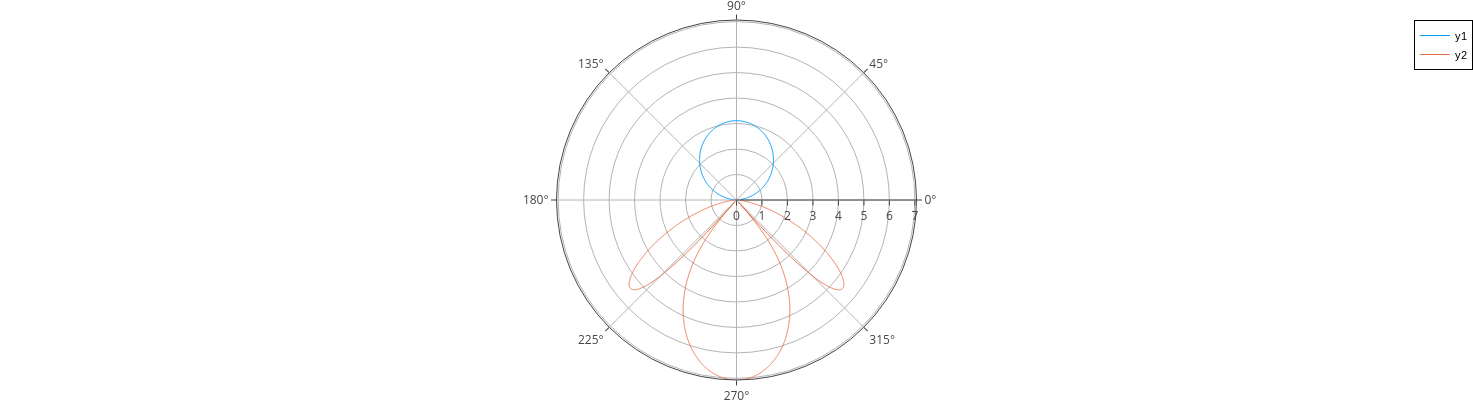

In [29]:
plot( θA,abs.(HsV).^2 .*Rf,proj=:polar)
plot!( θAn,c*abs.(HsVn).^2 .*Rf,proj=:polar)

In [30]:
sum(norm(HsV)^2 *Rf*0.01)

5.836993400414666

In [31]:
λArr = 400:10:700;
kArr = 2π./λArr;

In [32]:
opt = "down"

"down"

In [33]:
σOUPu = getσOUP(m,kArr,Rf,matScatter,rod,dThr,α,layer,"up");

In [34]:
σOUPd = getσOUP(m,kArr,Rf,matScatter,rod,dThr,α,layer,"down");

In [35]:
plot(λArr,σOUPu)
plot!(λArr,σOUPd)

In [36]:
str = rod;

In [37]:
k₁ = layer.mat[1].k(k0)
n₁ = layer.mat[1].n(k0)

kₙ = layer.mat[end].k(k0)
nₙ = layer.mat[end].n(k0)

rtC = rtcoeffs(layer,k0,[0.,],"up")
rp = rtC.r.TM[1]; tp = rtC.t.TM[1] 

-2sqrt(2π/(k₁))*real(rp*conj(getHₛ(π/2,Rf,ϕ,H,k0,m,str,layer))*sqrt(Rf)*exp(im*k₁*Rf)*exp(-im*π/4))

-15.538684538558536

In [38]:
-2*c*sqrt(2π/(kₙ))*real(tp*conj(getHₛ(-π/2,Rf,ϕ,H,k0,m,str,layer))*sqrt(Rf)*exp(im*kₙ*Rf)*exp(-im*π/4))

97.89026185139316

In [39]:
k0

0.011855066617319974

In [40]:
σₐArr = getσₐ(m,kArr,matScatter,rod,dThr,α,"layer"; layer = layer,xP= (xm , 12), yP = (ym,yp,12));

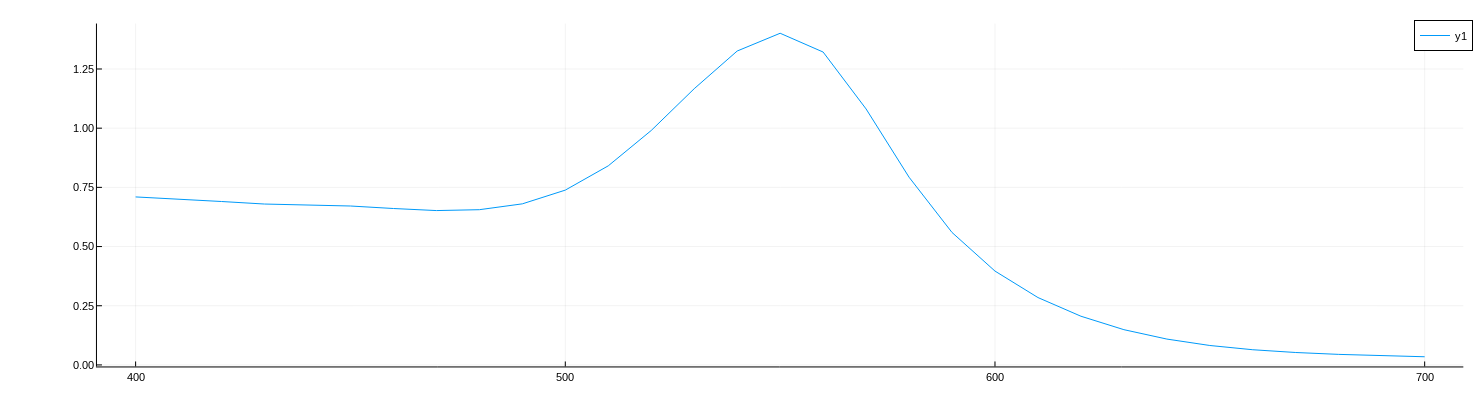

In [41]:
plot(λArr,σₐArr./w )

In [42]:
σEXTu,σEXTd = getσEXT(m,kArr,Rf,matScatter,rod,dThr,α,layer);

In [43]:
plot(λArr,σEXTd, label="Ext down",lw=1.2,c=:black,mark=:circle)
plot!(λArr,σEXTu, label="Ext up",lw=1.2,c=:black,mark=:hexagon)
plot!(λArr,σEXTu+σEXTd, label="Ext tot",lw=1.2,c=:black,ls=:dot)
plot!(λArr,σOUPu, label="Scatt. up",lw=1.2,c=:blue,ls=:dashdot,mark=:rect)
plot!(λArr,σOUPd, label="Scatt. down",lw=1.2,c=:blue,ls=:dashdot,mark=:diamond)
plot!(λArr,σₐArr, label="abs",lw=1.2,c=:brown ,ls=:dash)
scatter!(λArr,σₐArr+σOUPd+σOUPu,label="Abs+Scatt",c=:red,mark=:xcross,xlabel="Wavelength [nm]",  ylabel="Optical cross sections [nm]")